# RadarCOVID-Report

## Data Extraction

In [1]:
import datetime
import json
import logging
import os
import shutil
import tempfile
import textwrap
import uuid

import matplotlib.ticker
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
current_working_directory = os.environ.get("PWD")
if current_working_directory:
    os.chdir(current_working_directory)

sns.set()
matplotlib.rcParams["figure.figsize"] = (15, 6)

extraction_datetime = datetime.datetime.utcnow()
extraction_date = extraction_datetime.strftime("%Y-%m-%d")
extraction_previous_datetime = extraction_datetime - datetime.timedelta(days=1)
extraction_previous_date = extraction_previous_datetime.strftime("%Y-%m-%d")
extraction_date_with_hour = datetime.datetime.utcnow().strftime("%Y-%m-%d@%H")

### Constants

In [3]:
spain_region_country_name = "Spain"
spain_region_country_code = "ES"

backend_generation_days = 7 * 2
daily_summary_days = 7 * 4 * 3
daily_plot_days = 7 * 4
tek_dumps_load_limit = daily_summary_days + 1

### Parameters

In [4]:
active_region_parameter = os.environ.get("RADARCOVID_REPORT__ACTIVE_REGION")
if active_region_parameter:
    active_region_country_code, active_region_country_name = \
        active_region_parameter.split(":")
else:
    active_region_country_code, active_region_country_name = \
        spain_region_country_code, spain_region_country_name

### COVID-19 Cases

In [5]:
confirmed_df = pd.read_csv("https://covid19tracking.narrativa.com/csv/confirmed.csv")

radar_covid_countries = {active_region_country_name}

confirmed_df = confirmed_df[confirmed_df["Country_EN"].isin(radar_covid_countries)]
confirmed_df = confirmed_df[pd.isna(confirmed_df.Region)]
confirmed_df.head()

,Country_EN,Country_ES,Country_IT,Region,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,...,2020-10-13,2020-10-14,2020-10-15,2020-10-16,2020-10-17,2020-10-18,2020-10-19,2020-10-20,2020-10-21,2020-10-22
233,Spain,España,Spagna,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,896086.0,908056.0,921374.0,936560.0,936560.0,936560.0,974449.0,988322.0,1005295.0,1026281.0


In [6]:
confirmed_country_columns = list(filter(lambda x: x.startswith("Country_"), confirmed_df.columns))
confirmed_regional_columns = confirmed_country_columns + ["Region"]
confirmed_df.drop(columns=confirmed_regional_columns, inplace=True)
confirmed_df.head()

,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,...,2020-10-13,2020-10-14,2020-10-15,2020-10-16,2020-10-17,2020-10-18,2020-10-19,2020-10-20,2020-10-21,2020-10-22
233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,896086.0,908056.0,921374.0,936560.0,936560.0,936560.0,974449.0,988322.0,1005295.0,1026281.0


In [7]:
confirmed_df = confirmed_df.sum().to_frame()
confirmed_df.tail()

,0
2020-10-18,936560.0
2020-10-19,974449.0
2020-10-20,988322.0
2020-10-21,1005295.0
2020-10-22,1026281.0


In [8]:
confirmed_df.reset_index(inplace=True)
confirmed_df.columns = ["sample_date_string", "cumulative_cases"]
confirmed_df.sort_values("sample_date_string", inplace=True)
confirmed_df["new_cases"] = confirmed_df.cumulative_cases.diff()
confirmed_df["covid_cases"] = confirmed_df.new_cases.rolling(7).mean().round()
confirmed_df.tail()

,sample_date_string,cumulative_cases,new_cases,covid_cases
269,2020-10-18,936560.0,0.0,10778.0
270,2020-10-19,974449.0,37889.0,12212.0
271,2020-10-20,988322.0,13873.0,13177.0
272,2020-10-21,1005295.0,16973.0,13891.0
273,2020-10-22,1026281.0,20986.0,14987.0


In [9]:
extraction_date_confirmed_df = \
    confirmed_df[confirmed_df.sample_date_string == extraction_date]
extraction_previous_date_confirmed_df = \
    confirmed_df[confirmed_df.sample_date_string == extraction_previous_date].copy()

if extraction_date_confirmed_df.empty and \
    not extraction_previous_date_confirmed_df.empty:
        extraction_previous_date_confirmed_df["sample_date_string"] = extraction_date
        extraction_previous_date_confirmed_df["new_cases"] = \
            extraction_previous_date_confirmed_df.covid_cases
        extraction_previous_date_confirmed_df["cumulative_cases"] = \
            extraction_previous_date_confirmed_df.new_cases + \
            extraction_previous_date_confirmed_df.cumulative_cases
        confirmed_df = confirmed_df.append(extraction_previous_date_confirmed_df)

confirmed_df["covid_cases"] = confirmed_df.covid_cases.fillna(0).astype(int)
confirmed_df.tail()

,sample_date_string,cumulative_cases,new_cases,covid_cases
270,2020-10-19,974449.0,37889.0,12212
271,2020-10-20,988322.0,13873.0,13177
272,2020-10-21,1005295.0,16973.0,13891
273,2020-10-22,1026281.0,20986.0,14987
273,2020-10-23,1041268.0,14987.0,14987


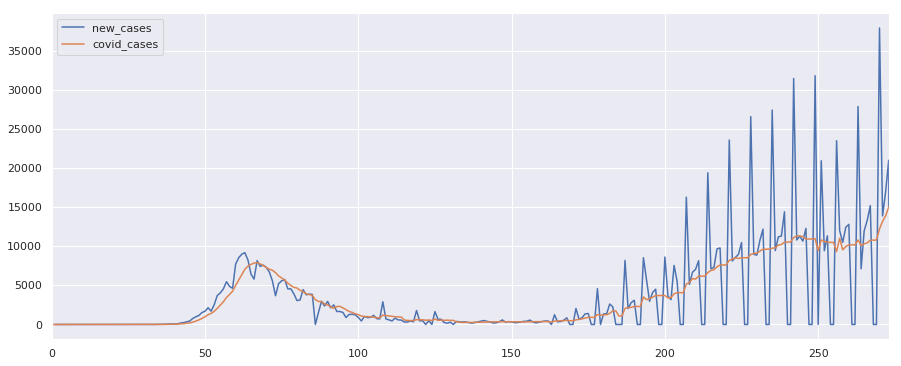

In [10]:
confirmed_df[["new_cases", "covid_cases"]].plot()

### Extract API TEKs

In [11]:
from Modules.ExposureNotification import exposure_notification_io

raw_zip_path_prefix = "Data/TEKs/Raw/"
fail_on_error_backend_identifiers = [active_region_country_code]
multi_region_exposure_keys_df = \
    exposure_notification_io.download_exposure_keys_from_backends(
        generation_days=backend_generation_days,
        fail_on_error_backend_identifiers=fail_on_error_backend_identifiers,
        save_raw_zip_path_prefix=raw_zip_path_prefix)
multi_region_exposure_keys_df["region"] = multi_region_exposure_keys_df["backend_identifier"]
multi_region_exposure_keys_df.rename(
    columns={
        "generation_datetime": "sample_datetime",
        "generation_date_string": "sample_date_string",
    },
    inplace=True)
multi_region_exposure_keys_df.head()

Traceback (most recent call last):
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/exposure_notification_io.py", line 91, in download_exposure_keys_from_backends
    backend_exposure_keys_df = downloader.download_exposure_keys_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/base.py", line 36, in download_exposure_keys_with_parameters
    self.generate_exposure_keys_export_endpoints_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/corona_warn_app.py", line 22, in generate_exposure_keys_export_endpoints_with_parameters
    response.raise_for_status()
  File "/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/requests/models.py", line 941, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 404 Client Error: Not Found for url: https://svc90.main.px.t-online.de/versi

Traceback (most recent call last):
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/exposure_notification_io.py", line 91, in download_exposure_keys_from_backends
    backend_exposure_keys_df = downloader.download_exposure_keys_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/base.py", line 36, in download_exposure_keys_with_parameters
    self.generate_exposure_keys_export_endpoints_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/corona_warn_app.py", line 22, in generate_exposure_keys_export_endpoints_with_parameters
    response.raise_for_status()
  File "/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/requests/models.py", line 941, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 404 Client Error: Not Found for url: https://svc90.main.px.t-online.de/versi

Traceback (most recent call last):
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/exposure_notification_io.py", line 91, in download_exposure_keys_from_backends
    backend_exposure_keys_df = downloader.download_exposure_keys_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/base.py", line 36, in download_exposure_keys_with_parameters
    self.generate_exposure_keys_export_endpoints_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/corona_warn_app.py", line 22, in generate_exposure_keys_export_endpoints_with_parameters
    response.raise_for_status()
  File "/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/requests/models.py", line 941, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 404 Client Error: Not Found for url: https://svc90.main.px.t-online.de/versi

Traceback (most recent call last):
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/exposure_notification_io.py", line 91, in download_exposure_keys_from_backends
    backend_exposure_keys_df = downloader.download_exposure_keys_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/base.py", line 36, in download_exposure_keys_with_parameters
    self.generate_exposure_keys_export_endpoints_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/immuni.py", line 27, in generate_exposure_keys_export_endpoints_with_parameters
    response.raise_for_status()
  File "/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/requests/models.py", line 941, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 404 Client Error: Not Found for url: https://get.immuni.gov.it/v1/keys/eu/ES/index


Traceback (most recent call last):
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/exposure_notification_io.py", line 91, in download_exposure_keys_from_backends
    backend_exposure_keys_df = downloader.download_exposure_keys_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/base.py", line 36, in download_exposure_keys_with_parameters
    self.generate_exposure_keys_export_endpoints_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/immuni.py", line 27, in generate_exposure_keys_export_endpoints_with_parameters
    response.raise_for_status()
  File "/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/requests/models.py", line 941, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 404 Client Error: Not Found for url: https://get.immuni.gov.it/v1/keys/eu/IE/index


Traceback (most recent call last):
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/exposure_notification_io.py", line 91, in download_exposure_keys_from_backends
    backend_exposure_keys_df = downloader.download_exposure_keys_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/base.py", line 36, in download_exposure_keys_with_parameters
    self.generate_exposure_keys_export_endpoints_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/immuni.py", line 27, in generate_exposure_keys_export_endpoints_with_parameters
    response.raise_for_status()
  File "/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/requests/models.py", line 941, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 404 Client Error: Not Found for url: https://get.immuni.gov.it/v1/keys/eu/DE/index


,sample_datetime,sample_date_string,region,verification_key_version,verification_key_id,signature_algorithm,key_data,rolling_start_interval_number,rolling_period,transmission_risk_level,backend_identifier
0,2020-10-23,2020-10-23,ES,V1,214,1.2.840.10045.4.3.2,3cec83a6-a2a6-2cec-3e9d-70e52cafa3f1,2672352,60,0,ES
1,2020-10-23,2020-10-23,ES,V1,214,1.2.840.10045.4.3.2,c869d4d3-dd9e-ffef-27ba-7936a18d283b,2672352,59,0,ES
2,2020-10-23,2020-10-23,ES,V1,214,1.2.840.10045.4.3.2,5c804d70-91c1-721b-b09a-ccd55ad5af73,2672352,59,0,ES
3,2020-10-23,2020-10-23,ES,V1,214,1.2.840.10045.4.3.2,c4fefc2f-a01f-b0cf-a275-d80ce0a24099,2672352,58,0,ES
4,2020-10-23,2020-10-23,ES,V1,214,1.2.840.10045.4.3.2,58c0c9a3-2c38-cccb-7a42-5984c077552b,2672352,58,0,ES


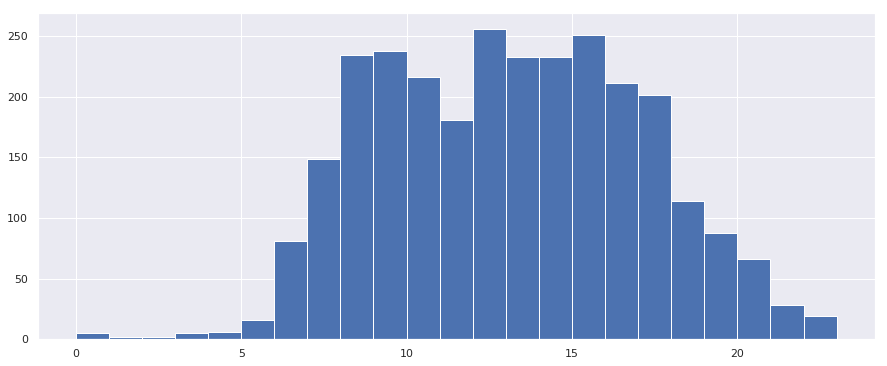

In [12]:
early_teks_df = multi_region_exposure_keys_df[
    multi_region_exposure_keys_df.rolling_period < 144].copy()
early_teks_df["rolling_period_in_hours"] = early_teks_df.rolling_period / 6
early_teks_df[early_teks_df.sample_date_string != extraction_date] \
    .rolling_period_in_hours.hist(bins=list(range(24)))

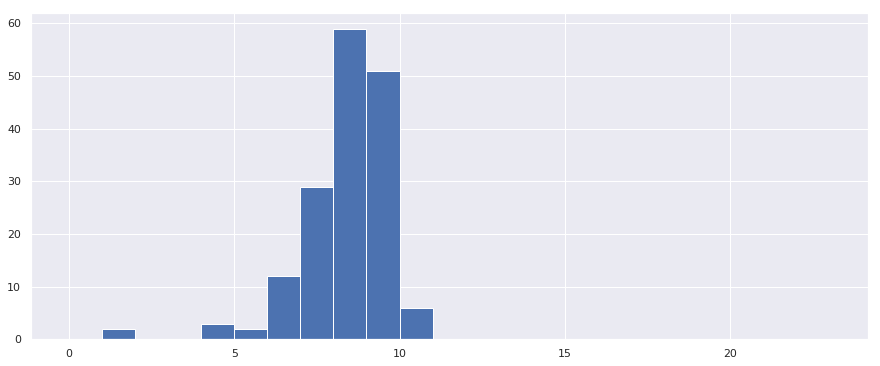

In [13]:
early_teks_df[early_teks_df.sample_date_string == extraction_date] \
    .rolling_period_in_hours.hist(bins=list(range(24)))

In [14]:
multi_region_exposure_keys_df = multi_region_exposure_keys_df[[
    "sample_date_string", "region", "key_data"]]
multi_region_exposure_keys_df.head()

,sample_date_string,region,key_data
0,2020-10-23,ES,3cec83a6-a2a6-2cec-3e9d-70e52cafa3f1
1,2020-10-23,ES,c869d4d3-dd9e-ffef-27ba-7936a18d283b
2,2020-10-23,ES,5c804d70-91c1-721b-b09a-ccd55ad5af73
3,2020-10-23,ES,c4fefc2f-a01f-b0cf-a275-d80ce0a24099
4,2020-10-23,ES,58c0c9a3-2c38-cccb-7a42-5984c077552b


In [15]:
active_regions = \
    multi_region_exposure_keys_df.groupby("region").key_data.nunique().sort_values().index.unique().tolist()
active_regions

['EE', 'IT-IT', 'BE@TST', 'MT', 'PT', 'ES@PRE', 'ES', 'BE', 'IT', 'CH', 'DE']

In [16]:
multi_region_summary_df = multi_region_exposure_keys_df.groupby(
    ["sample_date_string", "region"]).key_data.nunique().reset_index() \
    .pivot(index="sample_date_string", columns="region") \
    .sort_index(ascending=False)
multi_region_summary_df.rename(
    columns={"key_data": "shared_teks_by_generation_date"},
    inplace=True)
multi_region_summary_df.rename_axis("sample_date", inplace=True)
multi_region_summary_df = multi_region_summary_df.fillna(0).astype(int)
multi_region_summary_df = multi_region_summary_df.head(backend_generation_days)
multi_region_summary_df.head()

shared_teks_by_generation_date                                     \
region                                  BE BE@TST    CH    DE  EE   ES ES@PRE   
sample_date                                                                     
2020-10-23                               0      0   111     0   0   45      8   
2020-10-22                               0      0   569     0   3  230     44   
2020-10-21                             493     47  1058  1592  10  330    160   
2020-10-20                             797     48  1541  2821  14  454    158   
2020-10-19                             988     50  1983  3622  15  542    200   

                                   
region         IT IT-IT   MT   PT  
sample_date                        
2020-10-23      0     0    0    0  
2020-10-22     47     0  104   40  
2020-10-21    124     0  108   80  
2020-10-20   1144     0  114  111  
2020-10-19   1592    76  116  152

In [17]:
multi_region_without_active_region_exposure_keys_df = \
    multi_region_exposure_keys_df[multi_region_exposure_keys_df.region != active_region_country_code]
multi_region_without_active_region = \
    multi_region_without_active_region_exposure_keys_df.groupby("region").key_data.nunique().sort_values().index.unique().tolist()
multi_region_without_active_region

['EE', 'IT-IT', 'BE@TST', 'MT', 'PT', 'ES@PRE', 'BE', 'IT', 'CH', 'DE']

In [18]:
exposure_keys_summary_df = multi_region_exposure_keys_df[
    multi_region_exposure_keys_df.region == active_region_country_code]
exposure_keys_summary_df.drop(columns=["region"], inplace=True)
exposure_keys_summary_df = \
    exposure_keys_summary_df.groupby(["sample_date_string"]).key_data.nunique().to_frame()
exposure_keys_summary_df = \
    exposure_keys_summary_df.reset_index().set_index("sample_date_string")
exposure_keys_summary_df.sort_index(ascending=False, inplace=True)
exposure_keys_summary_df.rename(columns={"key_data": "shared_teks_by_generation_date"}, inplace=True)
exposure_keys_summary_df.head()

/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/pandas/core/frame.py:4110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,shared_teks_by_generation_date
sample_date_string,
2020-10-23,45
2020-10-22,230
2020-10-21,330
2020-10-20,454
2020-10-19,542


### Dump API TEKs

In [19]:
tek_list_df = multi_region_exposure_keys_df[
    ["sample_date_string", "region", "key_data"]].copy()
tek_list_df["key_data"] = tek_list_df["key_data"].apply(str)
tek_list_df.rename(columns={
    "sample_date_string": "sample_date",
    "key_data": "tek_list"}, inplace=True)
tek_list_df = tek_list_df.groupby(
    ["sample_date", "region"]).tek_list.unique().reset_index()
tek_list_df["extraction_date"] = extraction_date
tek_list_df["extraction_date_with_hour"] = extraction_date_with_hour

tek_list_path_prefix = "Data/TEKs/"
tek_list_current_path = tek_list_path_prefix + f"/Current/RadarCOVID-TEKs.json"
tek_list_daily_path = tek_list_path_prefix + f"Daily/RadarCOVID-TEKs-{extraction_date}.json"
tek_list_hourly_path = tek_list_path_prefix + f"Hourly/RadarCOVID-TEKs-{extraction_date_with_hour}.json"

for path in [tek_list_current_path, tek_list_daily_path, tek_list_hourly_path]:
    os.makedirs(os.path.dirname(path), exist_ok=True)

tek_list_df.drop(columns=["extraction_date", "extraction_date_with_hour"]).to_json(
    tek_list_current_path,
    lines=True, orient="records")
tek_list_df.drop(columns=["extraction_date_with_hour"]).to_json(
    tek_list_daily_path,
    lines=True, orient="records")
tek_list_df.to_json(
    tek_list_hourly_path,
    lines=True, orient="records")
tek_list_df.head()

,sample_date,region,tek_list,extraction_date,extraction_date_with_hour
0,2020-10-10,BE,"[06862570-aeed-b5e1-f52b-c84f25b8e6cf, 07be94b...",2020-10-23,2020-10-23@10
1,2020-10-10,BE@TST,"[017a5061-4411-f148-1b6e-fc39b08774b0, 054901d...",2020-10-23,2020-10-23@10
2,2020-10-10,CH,"[5a030d7b-155a-204e-17e1-830c14815815, f42a4b8...",2020-10-23,2020-10-23@10
3,2020-10-10,DE,"[00882865-9954-1bc3-c24d-df00d63050d2, 00d72d3...",2020-10-23,2020-10-23@10
4,2020-10-10,EE,"[281e3d47-d5ae-d556-019e-7dd151960654, 5e994cd...",2020-10-23,2020-10-23@10


### Load TEK Dumps

In [20]:
import glob

def load_extracted_teks(mode, region=None, limit=None) -> pd.DataFrame:
    extracted_teks_df = pd.DataFrame(columns=["region"])
    paths = list(reversed(sorted(glob.glob(tek_list_path_prefix + mode + "/RadarCOVID-TEKs-*.json"))))
    if limit:
        paths = paths[:limit]
    for path in paths:
        logging.info(f"Loading TEKs from '{path}'...")
        iteration_extracted_teks_df = pd.read_json(path, lines=True)
        extracted_teks_df = extracted_teks_df.append(
            iteration_extracted_teks_df, sort=False)
    extracted_teks_df["region"] = \
        extracted_teks_df.region.fillna(spain_region_country_code).copy()
    if region:
        extracted_teks_df = \
            extracted_teks_df[extracted_teks_df.region == region]
    return extracted_teks_df

In [21]:
daily_extracted_teks_df = load_extracted_teks(
    mode="Daily",
    region=active_region_country_code,
    limit=tek_dumps_load_limit)
daily_extracted_teks_df.head()

,region,sample_date,tek_list,extraction_date,extraction_date_with_hour
5,ES,2020-10-10,"[bcd68f2c-0117-7b8a-c1bf-1f7969be087a, 5cdf321...",2020-10-23,NaN
16,ES,2020-10-11,"[cc14a8f6-049d-fc1a-a2a3-95940c7b3ac1, 1070dc5...",2020-10-23,NaN
27,ES,2020-10-12,"[1805d790-3d2f-db0d-e32a-ed23bed05e35, e2be113...",2020-10-23,NaN
38,ES,2020-10-13,"[afd4d493-1de8-729f-b6f7-807f55e671f1, 6b21174...",2020-10-23,NaN
49,ES,2020-10-14,"[0a853cf2-7228-e7d8-1b09-0b2da16d051c, 8ea3911...",2020-10-23,NaN


In [22]:
exposure_keys_summary_df_ = daily_extracted_teks_df \
    .sort_values("extraction_date", ascending=False) \
    .groupby("sample_date").tek_list.first() \
    .to_frame()
exposure_keys_summary_df_.index.name = "sample_date_string"
exposure_keys_summary_df_["tek_list"] = \
    exposure_keys_summary_df_.tek_list.apply(len)
exposure_keys_summary_df_ = exposure_keys_summary_df_ \
    .rename(columns={"tek_list": "shared_teks_by_generation_date"}) \
    .sort_index(ascending=False)
exposure_keys_summary_df = exposure_keys_summary_df_
exposure_keys_summary_df.head()

,shared_teks_by_generation_date
sample_date_string,
2020-10-23,45
2020-10-22,230
2020-10-21,330
2020-10-20,454
2020-10-19,542


### Daily New TEKs

In [23]:
tek_list_df = daily_extracted_teks_df.groupby("extraction_date").tek_list.apply(
    lambda x: set(sum(x, []))).reset_index()
tek_list_df = tek_list_df.set_index("extraction_date").sort_index(ascending=True)
tek_list_df.head()

,tek_list
extraction_date,
2020-08-29,"{651a3e8e-54cd-49f3-1f31-36858fc4e18d, b3d72d8..."
2020-08-30,"{651a3e8e-54cd-49f3-1f31-36858fc4e18d, b3d72d8..."
2020-08-31,"{651a3e8e-54cd-49f3-1f31-36858fc4e18d, b3d72d8..."
2020-09-01,"{651a3e8e-54cd-49f3-1f31-36858fc4e18d, b3d72d8..."
2020-09-02,"{651a3e8e-54cd-49f3-1f31-36858fc4e18d, b3d72d8..."


In [24]:
def compute_teks_by_generation_and_upload_date(date):
    day_new_teks_set_df = tek_list_df.copy().diff()
    try:
        day_new_teks_set = day_new_teks_set_df[
            day_new_teks_set_df.index == date].tek_list.item()
    except ValueError:
        day_new_teks_set = None
    if pd.isna(day_new_teks_set):
        day_new_teks_set = set()
    day_new_teks_df = daily_extracted_teks_df[
        daily_extracted_teks_df.extraction_date == date].copy()
    day_new_teks_df["shared_teks"] = \
        day_new_teks_df.tek_list.apply(lambda x: set(x).intersection(day_new_teks_set))
    day_new_teks_df["shared_teks"] = \
        day_new_teks_df.shared_teks.apply(len)
    day_new_teks_df["upload_date"] = date
    day_new_teks_df.rename(columns={"sample_date": "generation_date"}, inplace=True)
    day_new_teks_df = day_new_teks_df[
        ["upload_date", "generation_date", "shared_teks"]]
    day_new_teks_df["generation_to_upload_days"] = \
        (pd.to_datetime(day_new_teks_df.upload_date) -
         pd.to_datetime(day_new_teks_df.generation_date)).dt.days
    day_new_teks_df = day_new_teks_df[day_new_teks_df.shared_teks > 0]
    return day_new_teks_df

shared_teks_generation_to_upload_df = pd.DataFrame()
for upload_date in daily_extracted_teks_df.extraction_date.unique():
    shared_teks_generation_to_upload_df = \
        shared_teks_generation_to_upload_df.append(
            compute_teks_by_generation_and_upload_date(date=upload_date))
shared_teks_generation_to_upload_df \
    .sort_values(["upload_date", "generation_date"], ascending=False, inplace=True)
shared_teks_generation_to_upload_df.tail()

<ipython-input-24-827222b35590>:4: FutureWarning: `item` has been deprecated and will be removed in a future version
  day_new_teks_set = day_new_teks_set_df[


,upload_date,generation_date,shared_teks,generation_to_upload_days
10,2020-08-30,2020-08-29,16,1
9,2020-08-30,2020-08-28,5,2
8,2020-08-30,2020-08-27,3,3
7,2020-08-30,2020-08-26,3,4
6,2020-08-30,2020-08-25,2,5


In [25]:
today_new_teks_df = \
    shared_teks_generation_to_upload_df[
        shared_teks_generation_to_upload_df.upload_date == extraction_date].copy()
today_new_teks_df.tail()

,upload_date,generation_date,shared_teks,generation_to_upload_days
71,2020-10-23,2020-10-16,8,7
60,2020-10-23,2020-10-15,5,8
49,2020-10-23,2020-10-14,3,9
38,2020-10-23,2020-10-13,1,10
27,2020-10-23,2020-10-12,1,11


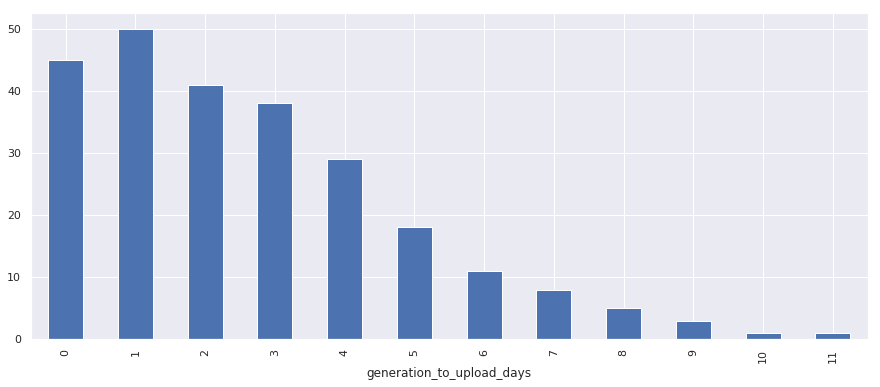

In [26]:
if not today_new_teks_df.empty:
    today_new_teks_df.set_index("generation_to_upload_days") \
        .sort_index().shared_teks.plot.bar()

In [27]:
generation_to_upload_period_pivot_df = \
    shared_teks_generation_to_upload_df[
        ["upload_date", "generation_to_upload_days", "shared_teks"]] \
        .pivot(index="upload_date", columns="generation_to_upload_days") \
        .sort_index(ascending=False).fillna(0).astype(int) \
        .droplevel(level=0, axis=1)
generation_to_upload_period_pivot_df.head()

generation_to_upload_days,0,1,2,3,4,5,6,7,8,9,10,11,12,13
upload_date,,,,,,,,,,,,,,
2020-10-23,45,50,41,38,29,18,11,8,5,3,1,1,0,0
2020-10-22,180,132,114,100,76,51,26,18,10,6,4,4,3,2
2020-10-21,157,153,136,120,97,62,34,28,20,15,9,4,3,3
2020-10-20,149,135,119,106,79,59,47,25,21,13,8,6,3,2
2020-10-19,142,123,118,105,86,72,45,33,22,17,12,9,4,3


In [28]:
new_tek_df = tek_list_df.diff().tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else None).to_frame().reset_index()
new_tek_df.rename(columns={
    "tek_list": "shared_teks_by_upload_date",
    "extraction_date": "sample_date_string",}, inplace=True)
new_tek_df.tail()

,sample_date_string,shared_teks_by_upload_date
51,2020-10-19,791.0
52,2020-10-20,772.0
53,2020-10-21,841.0
54,2020-10-22,726.0
55,2020-10-23,250.0


In [29]:
estimated_shared_diagnoses_df = daily_extracted_teks_df.copy()
estimated_shared_diagnoses_df["new_sample_extraction_date"] = \
    pd.to_datetime(estimated_shared_diagnoses_df.sample_date) + datetime.timedelta(1)
estimated_shared_diagnoses_df["extraction_date"] = pd.to_datetime(estimated_shared_diagnoses_df.extraction_date)
estimated_shared_diagnoses_df["sample_date"] = pd.to_datetime(estimated_shared_diagnoses_df.sample_date)
estimated_shared_diagnoses_df.head()

,region,sample_date,tek_list,extraction_date,extraction_date_with_hour,new_sample_extraction_date
5,ES,2020-10-10,"[bcd68f2c-0117-7b8a-c1bf-1f7969be087a, 5cdf321...",2020-10-23,NaN,2020-10-11
16,ES,2020-10-11,"[cc14a8f6-049d-fc1a-a2a3-95940c7b3ac1, 1070dc5...",2020-10-23,NaN,2020-10-12
27,ES,2020-10-12,"[1805d790-3d2f-db0d-e32a-ed23bed05e35, e2be113...",2020-10-23,NaN,2020-10-13
38,ES,2020-10-13,"[afd4d493-1de8-729f-b6f7-807f55e671f1, 6b21174...",2020-10-23,NaN,2020-10-14
49,ES,2020-10-14,"[0a853cf2-7228-e7d8-1b09-0b2da16d051c, 8ea3911...",2020-10-23,NaN,2020-10-15


In [30]:
# Sometimes TEKs from the same day are uploaded, we do not count them as new TEK devices:
same_day_tek_list_df = estimated_shared_diagnoses_df[
    estimated_shared_diagnoses_df.sample_date == estimated_shared_diagnoses_df.extraction_date].copy()
same_day_tek_list_df = same_day_tek_list_df[["extraction_date", "tek_list"]].rename(
    columns={"tek_list": "same_day_tek_list"})
same_day_tek_list_df.head()

,extraction_date,same_day_tek_list
138,2020-10-23,"[3cec83a6-a2a6-2cec-3e9d-70e52cafa3f1, c869d4d..."
139,2020-10-22,"[ffcfb805-c03e-e043-997b-fd875bc22cf2, 8e0508d..."
90,2020-10-21,"[63d1502a-a158-a5d2-001a-cbb82b9abcf5, ed1bc81..."
78,2020-10-20,"[97b27565-a475-f559-44f7-2b692ee719c3, a031a2f..."
78,2020-10-19,"[49c35d4b-f069-88fd-c596-f1e5dea1fc8b, b9dc5ad..."


In [31]:
shared_teks_uploaded_on_generation_date_df = same_day_tek_list_df.rename(
    columns={
        "extraction_date": "sample_date_string",
        "same_day_tek_list": "shared_teks_uploaded_on_generation_date",
    })
shared_teks_uploaded_on_generation_date_df.shared_teks_uploaded_on_generation_date = \
 shared_teks_uploaded_on_generation_date_df.shared_teks_uploaded_on_generation_date.apply(len)
shared_teks_uploaded_on_generation_date_df.head()
shared_teks_uploaded_on_generation_date_df["sample_date_string"] = \
    shared_teks_uploaded_on_generation_date_df.sample_date_string.dt.strftime("%Y-%m-%d")
shared_teks_uploaded_on_generation_date_df.head()

,sample_date_string,shared_teks_uploaded_on_generation_date
138,2020-10-23,45
139,2020-10-22,180
90,2020-10-21,157
78,2020-10-20,149
78,2020-10-19,142


In [32]:
estimated_shared_diagnoses_df = estimated_shared_diagnoses_df[
    estimated_shared_diagnoses_df.new_sample_extraction_date == estimated_shared_diagnoses_df.extraction_date]
estimated_shared_diagnoses_df.head()

,region,sample_date,tek_list,extraction_date,extraction_date_with_hour,new_sample_extraction_date
132,ES,2020-10-22,"[addc3e79-2976-0327-2f9f-d74493f77ac9, ff7d270...",2020-10-23,NaN,2020-10-23
133,ES,2020-10-21,"[40ae3e69-12c6-0482-2912-ea87d48b1aa3, 1afec6b...",2020-10-22,NaN,2020-10-22
85,ES,2020-10-20,"[0f0e336e-b1c9-a45e-3043-5ed28b80e1b0, e143507...",2020-10-21,NaN,2020-10-21
73,ES,2020-10-19,"[1c849f04-e59b-7f45-7e6b-e13356aec58b, 53ea152...",2020-10-20,NaN,2020-10-20
73,ES,2020-10-18,"[d1d49196-d84e-b08c-f0b0-766022303d56, b51293d...",2020-10-19,NaN,2020-10-19


In [33]:
same_day_tek_list_df["extraction_date"] = \
    same_day_tek_list_df.extraction_date + datetime.timedelta(1)
estimated_shared_diagnoses_df = \
    estimated_shared_diagnoses_df.merge(same_day_tek_list_df, how="left", on=["extraction_date"])
estimated_shared_diagnoses_df["same_day_tek_list"] = \
    estimated_shared_diagnoses_df.same_day_tek_list.apply(lambda x: [] if x is np.nan else x)
estimated_shared_diagnoses_df.head()

,region,sample_date,tek_list,extraction_date,extraction_date_with_hour,new_sample_extraction_date,same_day_tek_list
0,ES,2020-10-22,"[addc3e79-2976-0327-2f9f-d74493f77ac9, ff7d270...",2020-10-23,NaN,2020-10-23,"[ffcfb805-c03e-e043-997b-fd875bc22cf2, 8e0508d..."
1,ES,2020-10-21,"[40ae3e69-12c6-0482-2912-ea87d48b1aa3, 1afec6b...",2020-10-22,NaN,2020-10-22,"[63d1502a-a158-a5d2-001a-cbb82b9abcf5, ed1bc81..."
2,ES,2020-10-20,"[0f0e336e-b1c9-a45e-3043-5ed28b80e1b0, e143507...",2020-10-21,NaN,2020-10-21,"[97b27565-a475-f559-44f7-2b692ee719c3, a031a2f..."
3,ES,2020-10-19,"[1c849f04-e59b-7f45-7e6b-e13356aec58b, 53ea152...",2020-10-20,NaN,2020-10-20,"[49c35d4b-f069-88fd-c596-f1e5dea1fc8b, b9dc5ad..."
4,ES,2020-10-18,"[d1d49196-d84e-b08c-f0b0-766022303d56, b51293d...",2020-10-19,NaN,2020-10-19,"[655818ea-7b68-5788-d4c5-eaf6aefc8780, 7be987d..."


In [34]:
estimated_shared_diagnoses_df.set_index("extraction_date", inplace=True)
estimated_shared_diagnoses_df["shared_diagnoses"] = estimated_shared_diagnoses_df.apply(
    lambda x: len(set(x.tek_list).difference(x.same_day_tek_list)), axis=1).copy()
estimated_shared_diagnoses_df.reset_index(inplace=True)
estimated_shared_diagnoses_df.rename(columns={
    "extraction_date": "sample_date_string"}, inplace=True)
estimated_shared_diagnoses_df = estimated_shared_diagnoses_df[["sample_date_string", "shared_diagnoses"]]
estimated_shared_diagnoses_df["sample_date_string"] = estimated_shared_diagnoses_df.sample_date_string.dt.strftime("%Y-%m-%d")
estimated_shared_diagnoses_df.head()

,sample_date_string,shared_diagnoses
0,2020-10-23,50
1,2020-10-22,132
2,2020-10-21,153
3,2020-10-20,135
4,2020-10-19,123


### Hourly New TEKs

In [35]:
hourly_extracted_teks_df = load_extracted_teks(
    mode="Hourly", region=active_region_country_code, limit=25)
hourly_extracted_teks_df.head()

,region,sample_date,tek_list,extraction_date,extraction_date_with_hour
5,ES,2020-10-10,"[bcd68f2c-0117-7b8a-c1bf-1f7969be087a, 5cdf321...",2020-10-23,2020-10-23@10
16,ES,2020-10-11,"[cc14a8f6-049d-fc1a-a2a3-95940c7b3ac1, 1070dc5...",2020-10-23,2020-10-23@10
27,ES,2020-10-12,"[1805d790-3d2f-db0d-e32a-ed23bed05e35, e2be113...",2020-10-23,2020-10-23@10
38,ES,2020-10-13,"[afd4d493-1de8-729f-b6f7-807f55e671f1, 6b21174...",2020-10-23,2020-10-23@10
49,ES,2020-10-14,"[0a853cf2-7228-e7d8-1b09-0b2da16d051c, 8ea3911...",2020-10-23,2020-10-23@10


In [36]:
hourly_new_tek_count_df = hourly_extracted_teks_df \
    .groupby("extraction_date_with_hour").tek_list. \
    apply(lambda x: set(sum(x, []))).reset_index().copy()
hourly_new_tek_count_df = hourly_new_tek_count_df.set_index("extraction_date_with_hour") \
    .sort_index(ascending=True)

hourly_new_tek_count_df["new_tek_list"] = hourly_new_tek_count_df.tek_list.diff()
hourly_new_tek_count_df["new_tek_count"] = hourly_new_tek_count_df.new_tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else 0)
hourly_new_tek_count_df.rename(columns={
    "new_tek_count": "shared_teks_by_upload_date"}, inplace=True)
hourly_new_tek_count_df = hourly_new_tek_count_df.reset_index()[[
    "extraction_date_with_hour", "shared_teks_by_upload_date"]]
hourly_new_tek_count_df.head()

,extraction_date_with_hour,shared_teks_by_upload_date
0,2020-10-22@09,0
1,2020-10-22@10,152
2,2020-10-22@11,0
3,2020-10-22@12,117
4,2020-10-22@13,0


In [37]:
hourly_estimated_shared_diagnoses_df = hourly_extracted_teks_df.copy()
hourly_estimated_shared_diagnoses_df["new_sample_extraction_date"] = \
    pd.to_datetime(hourly_estimated_shared_diagnoses_df.sample_date) + datetime.timedelta(1)
hourly_estimated_shared_diagnoses_df["extraction_date"] = \
    pd.to_datetime(hourly_estimated_shared_diagnoses_df.extraction_date)

hourly_estimated_shared_diagnoses_df = hourly_estimated_shared_diagnoses_df[
    hourly_estimated_shared_diagnoses_df.new_sample_extraction_date ==
    hourly_estimated_shared_diagnoses_df.extraction_date]
hourly_estimated_shared_diagnoses_df = \
    hourly_estimated_shared_diagnoses_df.merge(same_day_tek_list_df, how="left", on=["extraction_date"])
hourly_estimated_shared_diagnoses_df["same_day_tek_list"] = \
    hourly_estimated_shared_diagnoses_df.same_day_tek_list.apply(lambda x: [] if x is np.nan else x)
hourly_estimated_shared_diagnoses_df["shared_diagnoses"] = hourly_estimated_shared_diagnoses_df.apply(
    lambda x: len(set(x.tek_list).difference(x.same_day_tek_list)), axis=1)
hourly_estimated_shared_diagnoses_df = \
    hourly_estimated_shared_diagnoses_df.sort_values("extraction_date_with_hour").copy()
hourly_estimated_shared_diagnoses_df["shared_diagnoses"] = hourly_estimated_shared_diagnoses_df \
    .groupby("extraction_date").shared_diagnoses.diff() \
    .fillna(0).astype(int)

hourly_estimated_shared_diagnoses_df.set_index("extraction_date_with_hour", inplace=True)
hourly_estimated_shared_diagnoses_df.reset_index(inplace=True)
hourly_estimated_shared_diagnoses_df = hourly_estimated_shared_diagnoses_df[[
    "extraction_date_with_hour", "shared_diagnoses"]]
hourly_estimated_shared_diagnoses_df.head()

,extraction_date_with_hour,shared_diagnoses
0,2020-10-22@09,0
1,2020-10-22@10,27
2,2020-10-22@11,0
3,2020-10-22@12,23
4,2020-10-22@13,0


In [38]:
hourly_summary_df = hourly_new_tek_count_df.merge(
    hourly_estimated_shared_diagnoses_df, on=["extraction_date_with_hour"], how="outer")
hourly_summary_df.set_index("extraction_date_with_hour", inplace=True)
hourly_summary_df = hourly_summary_df.fillna(0).astype(int).reset_index()
hourly_summary_df["datetime_utc"] = pd.to_datetime(
    hourly_summary_df.extraction_date_with_hour, format="%Y-%m-%d@%H")
hourly_summary_df.set_index("datetime_utc", inplace=True)
hourly_summary_df = hourly_summary_df.tail(-1)
hourly_summary_df.head()

,extraction_date_with_hour,shared_teks_by_upload_date,shared_diagnoses
datetime_utc,,,
2020-10-22 10:00:00,2020-10-22@10,152,27
2020-10-22 11:00:00,2020-10-22@11,0,0
2020-10-22 12:00:00,2020-10-22@12,117,23
2020-10-22 13:00:00,2020-10-22@13,0,0
2020-10-22 14:00:00,2020-10-22@14,79,11


### Data Merge

In [39]:
result_summary_df = exposure_keys_summary_df.merge(
    new_tek_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date
0,2020-10-23,45,250.0
1,2020-10-22,230,726.0
2,2020-10-21,330,841.0
3,2020-10-20,454,772.0
4,2020-10-19,542,791.0


In [40]:
result_summary_df = result_summary_df.merge(
    shared_teks_uploaded_on_generation_date_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date
0,2020-10-23,45,250.0,45.0
1,2020-10-22,230,726.0,180.0
2,2020-10-21,330,841.0,157.0
3,2020-10-20,454,772.0,149.0
4,2020-10-19,542,791.0,142.0


In [41]:
result_summary_df = result_summary_df.merge(
    estimated_shared_diagnoses_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
0,2020-10-23,45,250.0,45.0,50.0
1,2020-10-22,230,726.0,180.0,132.0
2,2020-10-21,330,841.0,157.0,153.0
3,2020-10-20,454,772.0,149.0,135.0
4,2020-10-19,542,791.0,142.0,123.0


In [42]:
result_summary_df = confirmed_df.tail(daily_summary_days).merge(
    result_summary_df, on=["sample_date_string"], how="left")
result_summary_df.head()

,sample_date_string,cumulative_cases,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
0,2020-08-01,288522.0,0.0,2300,NaN,NaN,NaN,NaN
1,2020-08-02,288522.0,0.0,2300,NaN,NaN,NaN,NaN
2,2020-08-03,297054.0,8532.0,3519,NaN,NaN,NaN,NaN
3,2020-08-04,302814.0,5760.0,3172,NaN,NaN,NaN,NaN
4,2020-08-05,305767.0,2953.0,3304,NaN,NaN,NaN,NaN


In [43]:
result_summary_df["sample_date"] = pd.to_datetime(result_summary_df.sample_date_string)
result_summary_df.set_index("sample_date", inplace=True)
result_summary_df.drop(columns=["sample_date_string"], inplace=True)
result_summary_df.sort_index(ascending=False, inplace=True)
result_summary_df.head()

,cumulative_cases,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
sample_date,,,,,,,
2020-10-23,1041268.0,14987.0,14987,45.0,250.0,45.0,50.0
2020-10-22,1026281.0,20986.0,14987,230.0,726.0,180.0,132.0
2020-10-21,1005295.0,16973.0,13891,330.0,841.0,157.0,153.0
2020-10-20,988322.0,13873.0,13177,454.0,772.0,149.0,135.0
2020-10-19,974449.0,37889.0,12212,542.0,791.0,142.0,123.0


In [44]:
with pd.option_context("mode.use_inf_as_na", True):
    result_summary_df = result_summary_df.fillna(0).astype(int)
    result_summary_df["teks_per_shared_diagnosis"] = \
        (result_summary_df.shared_teks_by_upload_date / result_summary_df.shared_diagnoses).fillna(0)
    result_summary_df["shared_diagnoses_per_covid_case"] = \
        (result_summary_df.shared_diagnoses / result_summary_df.covid_cases).fillna(0)

result_summary_df.head(daily_plot_days)

,cumulative_cases,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses,teks_per_shared_diagnosis,shared_diagnoses_per_covid_case
sample_date,,,,,,,,,
2020-10-23,1041268,14987,14987,45,250,45,50,5.000000,0.003336
2020-10-22,1026281,20986,14987,230,726,180,132,5.500000,0.008808
2020-10-21,1005295,16973,13891,330,841,157,153,5.496732,0.011014
2020-10-20,988322,13873,13177,454,772,149,135,5.718519,0.010245
2020-10-19,974449,37889,12212,542,791,142,123,6.430894,0.010072
2020-10-18,936560,0,10778,602,726,146,132,5.500000,0.012247
2020-10-17,936560,0,10778,689,767,174,138,5.557971,0.012804
2020-10-16,936560,15186,10778,681,769,149,141,5.453901,0.013082
2020-10-15,921374,13318,10436,708,671,151,175,3.834286,0.016769


In [45]:
weekly_result_summary_df = result_summary_df \
    .sort_index(ascending=True).fillna(0).rolling(7).agg({
    "covid_cases": "sum",
    "shared_teks_by_generation_date": "sum",
    "shared_teks_by_upload_date": "sum",
    "shared_diagnoses": "sum"
}).sort_index(ascending=False)

with pd.option_context("mode.use_inf_as_na", True):
    weekly_result_summary_df = weekly_result_summary_df.fillna(0).astype(int)
    weekly_result_summary_df["teks_per_shared_diagnosis"] = \
        (weekly_result_summary_df.shared_teks_by_upload_date / weekly_result_summary_df.shared_diagnoses).fillna(0)
    weekly_result_summary_df["shared_diagnoses_per_covid_case"] = \
        (weekly_result_summary_df.shared_diagnoses / weekly_result_summary_df.covid_cases).fillna(0)

weekly_result_summary_df.head()

,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_diagnoses,teks_per_shared_diagnosis,shared_diagnoses_per_covid_case
sample_date,,,,,,
2020-10-23,90810,2892,4873,863,5.646582,0.009503
2020-10-22,86601,3528,5392,954,5.651992,0.011016
2020-10-21,82050,4006,5337,997,5.353059,0.012151
2020-10-20,78467,4332,4959,977,5.075742,0.012451
2020-10-19,75387,4458,4521,954,4.738994,0.012655


In [46]:
last_7_days_summary = weekly_result_summary_df.to_dict(orient="records")[0]
last_7_days_summary

{'covid_cases': 90810,
 'shared_teks_by_generation_date': 2892,
 'shared_teks_by_upload_date': 4873,
 'shared_diagnoses': 863,
 'teks_per_shared_diagnosis': 5.6465816917728855,
 'shared_diagnoses_per_covid_case': 0.009503358660940426}

## Report Results

In [47]:
display_column_name_mapping = {
    "sample_date": "Sample\u00A0Date\u00A0(UTC)",
    "datetime_utc": "Timestamp (UTC)",
    "upload_date": "Upload Date (UTC)",
    "generation_to_upload_days": "Generation to Upload Period in Days",
    "region": "Backend Region",
    "covid_cases": "COVID-19 Cases (7-day Rolling Average)",
    "shared_teks_by_generation_date": "Shared TEKs by Generation Date",
    "shared_teks_by_upload_date": "Shared TEKs by Upload Date",
    "shared_diagnoses": "Shared Diagnoses (Estimation)",
    "teks_per_shared_diagnosis": "TEKs Uploaded per Shared Diagnosis",
    "shared_diagnoses_per_covid_case": "Usage Ratio (Fraction of Cases Which Shared Diagnosis)",
    "shared_teks_uploaded_on_generation_date": "Shared TEKs Uploaded on Generation Date",
}

In [48]:
summary_columns = [
    "covid_cases",
    "shared_teks_by_generation_date",
    "shared_teks_by_upload_date",
    "shared_teks_uploaded_on_generation_date",
    "shared_diagnoses",
    "teks_per_shared_diagnosis",
    "shared_diagnoses_per_covid_case",
]

### Daily Summary Table

In [49]:
result_summary_df_ = result_summary_df.copy()
result_summary_df = result_summary_df[summary_columns]
result_summary_with_display_names_df = result_summary_df \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping)
result_summary_with_display_names_df

,COVID-19 Cases (7-day Rolling Average),Shared TEKs by Generation Date,Shared TEKs by Upload Date,Shared TEKs Uploaded on Generation Date,Shared Diagnoses (Estimation),TEKs Uploaded per Shared Diagnosis,Usage Ratio (Fraction of Cases Which Shared Diagnosis)
Sample Date (UTC),,,,,,,
2020-10-23,14987,45,250,45,50,5.000000,0.003336
2020-10-22,14987,230,726,180,132,5.500000,0.008808
2020-10-21,13891,330,841,157,153,5.496732,0.011014
2020-10-20,13177,454,772,149,135,5.718519,0.010245
2020-10-19,12212,542,791,142,123,6.430894,0.010072
...,...,...,...,...,...,...,...
2020-08-05,3304,0,0,0,0,0.000000,0.000000
2020-08-04,3172,0,0,0,0,0.000000,0.000000
2020-08-03,3519,0,0,0,0,0.000000,0.000000


### Daily Summary Plots

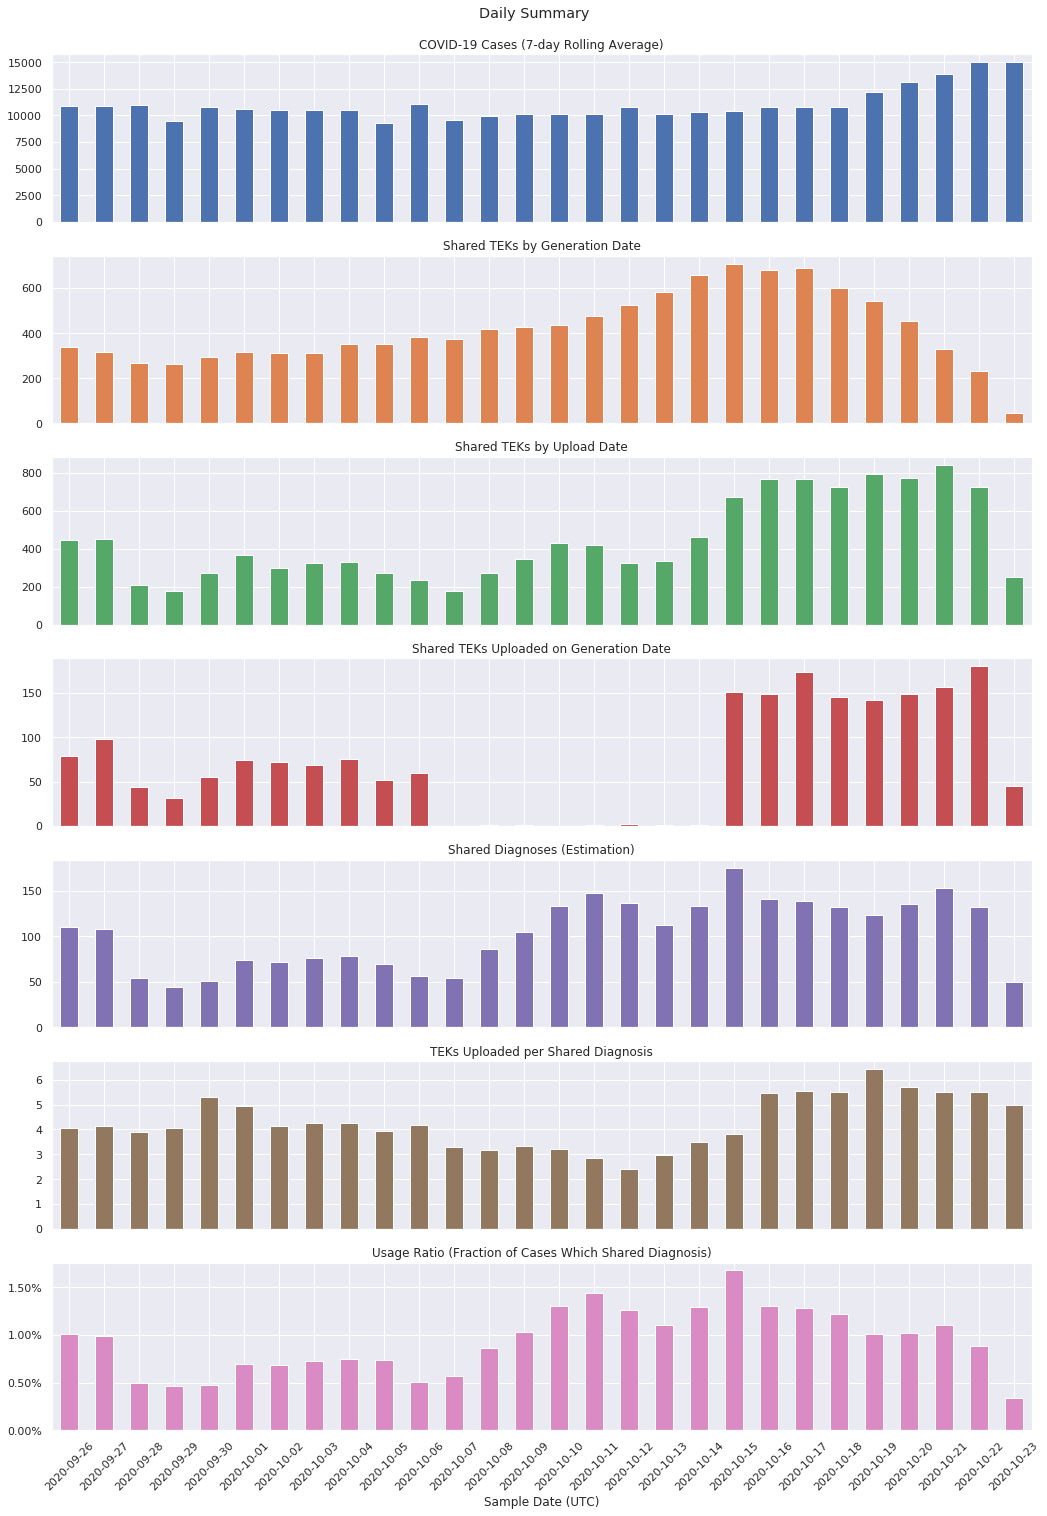

In [50]:
result_plot_summary_df = result_summary_df.head(daily_plot_days)[summary_columns] \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping)
summary_ax_list = result_plot_summary_df.sort_index(ascending=True).plot.bar(
    title=f"Daily Summary",
    rot=45, subplots=True, figsize=(15, 22), legend=False)
ax_ = summary_ax_list[-1]
ax_.get_figure().tight_layout()
ax_.get_figure().subplots_adjust(top=0.95)
ax_.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
_ = ax_.set_xticklabels(sorted(result_plot_summary_df.index.strftime("%Y-%m-%d").tolist()))

### Daily Generation to Upload Period Table

In [51]:
display_generation_to_upload_period_pivot_df = \
    generation_to_upload_period_pivot_df \
        .head(backend_generation_days)
display_generation_to_upload_period_pivot_df \
    .head(backend_generation_days) \
    .rename_axis(columns=display_column_name_mapping) \
    .rename_axis(index=display_column_name_mapping)

Generation to Upload Period in Days,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Upload Date (UTC),,,,,,,,,,,,,,
2020-10-23,45,50,41,38,29,18,11,8,5,3,1,1,0,0
2020-10-22,180,132,114,100,76,51,26,18,10,6,4,4,3,2
2020-10-21,157,153,136,120,97,62,34,28,20,15,9,4,3,3
2020-10-20,149,135,119,106,79,59,47,25,21,13,8,6,3,2
2020-10-19,142,123,118,105,86,72,45,33,22,17,12,9,4,3
2020-10-18,146,132,114,96,87,54,33,18,12,10,9,7,5,3
2020-10-17,174,138,118,108,84,54,32,19,15,11,7,4,2,1
2020-10-16,149,141,125,107,84,53,32,24,20,15,7,5,3,4
2020-10-15,151,175,104,86,58,38,23,14,8,6,4,2,1,1


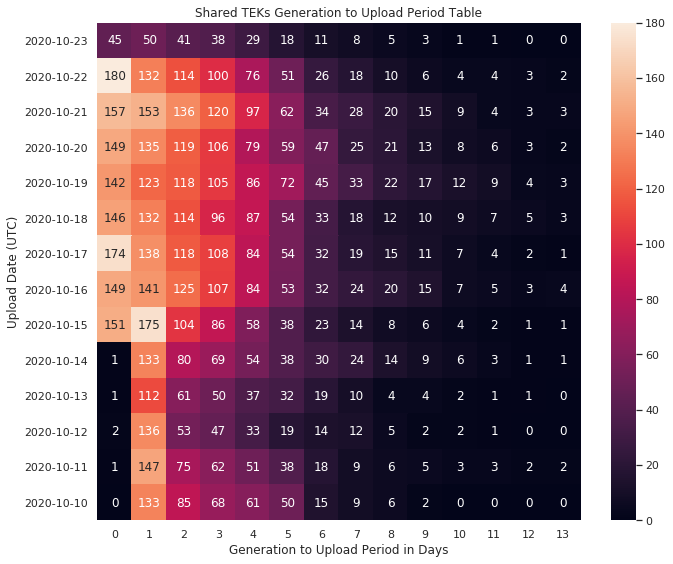

In [52]:
import matplotlib.pyplot as plt

fig, generation_to_upload_period_pivot_table_ax = plt.subplots(
    figsize=(10, 1 + 0.5 * len(display_generation_to_upload_period_pivot_df)))
generation_to_upload_period_pivot_table_ax.set_title(
    "Shared TEKs Generation to Upload Period Table")
sns.heatmap(
    data=display_generation_to_upload_period_pivot_df
        .rename_axis(columns=display_column_name_mapping)
        .rename_axis(index=display_column_name_mapping),
    fmt=".0f",
    annot=True,
    ax=generation_to_upload_period_pivot_table_ax)
generation_to_upload_period_pivot_table_ax.get_figure().tight_layout()

### Hourly Summary Plots 

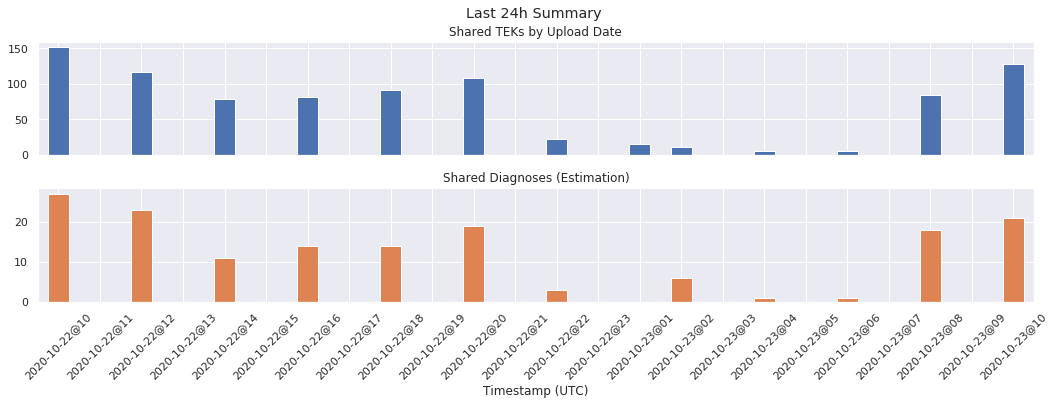

In [53]:
hourly_summary_ax_list = hourly_summary_df \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .plot.bar(
        title=f"Last 24h Summary",
        rot=45, subplots=True, legend=False)
ax_ = hourly_summary_ax_list[-1]
ax_.get_figure().tight_layout()
ax_.get_figure().subplots_adjust(top=0.9)
_ = ax_.set_xticklabels(sorted(hourly_summary_df.index.strftime("%Y-%m-%d@%H").tolist()))

### Publish Results

In [54]:
def get_temporary_image_path() -> str:
    return os.path.join(tempfile.gettempdir(), str(uuid.uuid4()) + ".png")

def save_temporary_plot_image(ax):
    if isinstance(ax, np.ndarray):
        ax = ax[0]
    media_path = get_temporary_image_path()
    ax.get_figure().savefig(media_path)
    return media_path

def save_temporary_dataframe_image(df):
    import dataframe_image as dfi
    media_path = get_temporary_image_path()
    dfi.export(df, media_path)
    return media_path

In [55]:
github_repository = os.environ.get("GITHUB_REPOSITORY")
if github_repository is None:
    github_repository = "pvieito/Radar-STATS"

github_project_base_url = "https://github.com/" + github_repository

display_formatters = {
    display_column_name_mapping["teks_per_shared_diagnosis"]: lambda x: f"{x:.2f}",
    display_column_name_mapping["shared_diagnoses_per_covid_case"]: lambda x: f"{x:.2%}",
}
daily_summary_table_html = result_summary_with_display_names_df \
    .head(daily_plot_days) \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .to_html(formatters=display_formatters)
multi_region_summary_table_html = multi_region_summary_df \
    .head(daily_plot_days) \
    .rename_axis(columns=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .rename_axis(index=display_column_name_mapping) \
    .to_html(formatters=display_formatters)

extraction_date_result_summary_df = \
    result_summary_df[result_summary_df.index == extraction_date]
extraction_date_result_hourly_summary_df = \
    hourly_summary_df[hourly_summary_df.extraction_date_with_hour == extraction_date_with_hour]

covid_cases = \
    extraction_date_result_summary_df.covid_cases.sum()
shared_teks_by_generation_date = \
    extraction_date_result_summary_df.shared_teks_by_generation_date.sum()
shared_teks_by_upload_date = \
    extraction_date_result_summary_df.shared_teks_by_upload_date.sum()
shared_diagnoses = \
    extraction_date_result_summary_df.shared_diagnoses.sum()
teks_per_shared_diagnosis = \
    extraction_date_result_summary_df.teks_per_shared_diagnosis.sum()
shared_diagnoses_per_covid_case = \
    extraction_date_result_summary_df.shared_diagnoses_per_covid_case.sum()

shared_teks_by_upload_date_last_hour = \
    extraction_date_result_hourly_summary_df.shared_teks_by_upload_date.sum().astype(int)
shared_diagnoses_last_hour = \
    extraction_date_result_hourly_summary_df.shared_diagnoses.sum().astype(int)

In [56]:
summary_plots_image_path = save_temporary_plot_image(
    ax=summary_ax_list)
summary_table_image_path = save_temporary_dataframe_image(
    df=result_summary_with_display_names_df)
hourly_summary_plots_image_path = save_temporary_plot_image(
    ax=hourly_summary_ax_list)
multi_region_summary_table_image_path = save_temporary_dataframe_image(
    df=multi_region_summary_df)
generation_to_upload_period_pivot_table_image_path = save_temporary_plot_image(
    ax=generation_to_upload_period_pivot_table_ax)

### Save Results

In [57]:
report_resources_path_prefix = "Data/Resources/Current/RadarCOVID-Report-"
result_summary_df.to_csv(
    report_resources_path_prefix + "Summary-Table.csv")
result_summary_df.to_html(
    report_resources_path_prefix + "Summary-Table.html")
hourly_summary_df.to_csv(
    report_resources_path_prefix + "Hourly-Summary-Table.csv")
multi_region_summary_df.to_csv(
    report_resources_path_prefix + "Multi-Region-Summary-Table.csv")
generation_to_upload_period_pivot_df.to_csv(
    report_resources_path_prefix + "Generation-Upload-Period-Table.csv")
_ = shutil.copyfile(
    summary_plots_image_path,
    report_resources_path_prefix + "Summary-Plots.png")
_ = shutil.copyfile(
    summary_table_image_path,
    report_resources_path_prefix + "Summary-Table.png")
_ = shutil.copyfile(
    hourly_summary_plots_image_path,
    report_resources_path_prefix + "Hourly-Summary-Plots.png")
_ = shutil.copyfile(
    multi_region_summary_table_image_path,
    report_resources_path_prefix + "Multi-Region-Summary-Table.png")
_ = shutil.copyfile(
    generation_to_upload_period_pivot_table_image_path,
    report_resources_path_prefix + "Generation-Upload-Period-Table.png")

### Publish Results as JSON

In [58]:
summary_results_api_df = result_summary_df.reset_index()
summary_results_api_df["sample_date_string"] = \
    summary_results_api_df["sample_date"].dt.strftime("%Y-%m-%d")

summary_results = dict(
    extraction_datetime=extraction_datetime,
    extraction_date=extraction_date,
    extraction_date_with_hour=extraction_date_with_hour,
    last_hour=dict(
        shared_teks_by_upload_date=shared_teks_by_upload_date_last_hour,
        shared_diagnoses=shared_diagnoses_last_hour,
    ),
    today=dict(
        covid_cases=covid_cases,
        shared_teks_by_generation_date=shared_teks_by_generation_date,
        shared_teks_by_upload_date=shared_teks_by_upload_date,
        shared_diagnoses=shared_diagnoses,
        teks_per_shared_diagnosis=teks_per_shared_diagnosis,
        shared_diagnoses_per_covid_case=shared_diagnoses_per_covid_case,
    ),
    last_7_days=last_7_days_summary,
    daily_results=summary_results_api_df.to_dict(orient="records"))
summary_results = \
    json.loads(pd.Series([summary_results]).to_json(orient="records"))[0]

with open(report_resources_path_prefix + "Summary-Results.json", "w") as f:
    json.dump(summary_results, f, indent=4)

### Publish on README

In [59]:
with open("Data/Templates/README.md", "r") as f:
    readme_contents = f.read()

readme_contents = readme_contents.format(
    extraction_date_with_hour=extraction_date_with_hour,
    github_project_base_url=github_project_base_url,
    daily_summary_table_html=daily_summary_table_html,
    multi_region_summary_table_html=multi_region_summary_table_html)

with open("README.md", "w") as f:
    f.write(readme_contents)

### Publish on Twitter

In [60]:
enable_share_to_twitter = os.environ.get("RADARCOVID_REPORT__ENABLE_PUBLISH_ON_TWITTER")
github_event_name = os.environ.get("GITHUB_EVENT_NAME")

if enable_share_to_twitter and github_event_name == "schedule":
    import tweepy

    twitter_api_auth_keys = os.environ["RADARCOVID_REPORT__TWITTER_API_AUTH_KEYS"]
    twitter_api_auth_keys = twitter_api_auth_keys.split(":")
    auth = tweepy.OAuthHandler(twitter_api_auth_keys[0], twitter_api_auth_keys[1])
    auth.set_access_token(twitter_api_auth_keys[2], twitter_api_auth_keys[3])

    api = tweepy.API(auth)

    summary_plots_media = api.media_upload(summary_plots_image_path)
    summary_table_media = api.media_upload(summary_table_image_path)
    generation_to_upload_period_pivot_table_image_media = api.media_upload(generation_to_upload_period_pivot_table_image_path)
    media_ids = [
        summary_plots_media.media_id,
        summary_table_media.media_id,
        generation_to_upload_period_pivot_table_image_media.media_id,
    ]

    status = textwrap.dedent(f"""
        #RadarCOVID Report – {extraction_date_with_hour}

        Today:
        - Uploaded TEKs: {shared_teks_by_upload_date:.0f} ({shared_teks_by_upload_date_last_hour:+d} last hour)
        - Shared Diagnoses: ≤{shared_diagnoses:.0f} ({shared_diagnoses_last_hour:+d} last hour)
        - TEKs per Diagnosis: ≥{teks_per_shared_diagnosis:.1f}
        - Usage Ratio: ≤{shared_diagnoses_per_covid_case:.2%}

        Week:
        - Shared Diagnoses: ≤{last_7_days_summary["shared_diagnoses"]:.0f}
        - Usage Ratio: ≤{last_7_days_summary["shared_diagnoses_per_covid_case"]:.2%}

        More Info: {github_project_base_url}#documentation
        """)
    status = status.encode(encoding="utf-8")
    api.update_status(status=status, media_ids=media_ids)